# Settings

In [ ]:
import numpy as np
import pandas as pd
import os
import copy
import math
import torch
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
# linear
from sklearn import linear_model
# non-linear
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
# NN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import regularizers as reg
import tensorflow as tf
# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error
# mount
from google.colab import drive
drive.mount('/content/drive')
# path
config = {
    'dir' : ['drive/MyDrive/aaaaa/data','/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/data/']
}
try:
  os.chdir(config['dir'][1])
except:
  os.chdir(config['dir'][0])
# validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
# graph
import matplotlib.pyplot as plt
# other
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [ ]:
%ls

capital.csv             index.csv                   price_week.csv
cleaned_data.xlsx       institutional_investor.csv  rapidsai-csp-utils/
condacolab_install.log  market.csv                  revenue.csv
credit.csv              model.pth                   temp_X
data.pickle             nn_pred.pickle              temp_y
esg.csv                 nn_ret.pickle
esg_rank.csv            price.csv


# gpu
if run xgboost and rfr with gpu
https://colab.research.google.com/drive/1xnTpVS194BJ0pOPuxN4GOmypdu2RvwdH

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py
!nvidia-smi

##### initialization of gpu (don't run)

In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

##### gpu check

In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

In [ ]:
if torch.cuda.is_available():
  import cuml
  import cudf

# Data preprocessing



In [ ]:
# 缺資料：index、capital
price = pd.read_csv("price_week.csv", encoding="big5")
revenue = pd.read_csv("revenue.csv", encoding="big5")
institution = pd.read_csv("institutional_investor.csv", encoding="big5")


##### 1. Revenue

In [ ]:
# ------------------------------
# date: set the release date to 10th of next month
revenue["營收發布日"] = pd.to_datetime(revenue["年月"], format = "%Y%m") + pd.DateOffset(days = 9) + pd.DateOffset(months = 1)

# ------------------------------
# na
cols = (revenue.isna().sum()).index
for k, i in enumerate(revenue.isna().sum()/len(revenue)):
  if i > 0.2:
    revenue.drop(cols[k], axis = 1, inplace = True)
print(revenue.shape)
corp = revenue["證券代碼"].unique()
rev_ = pd.DataFrame()
for i in corp:
  group = revenue[revenue["證券代碼"] == i]
  group = group.fillna(method = "ffill")
  group = group.dropna()
  rev_ = pd.concat([rev_, group], axis = 0)
print(rev_.shape)

# ------------------------------
# drop column: drop nonnumerical
nonum_col = []
for i in rev_.columns:
  if isinstance(rev_[i].iloc[1], np.float64):
    pass
  else:
    # print(i)
    nonum_col.append(i)
print(nonum_col)
rev_num = rev_.drop(nonum_col, axis = 1)
rev_nonum = rev_[nonum_col]
rev_nonum = rev_nonum.drop(["年月"], axis = 1)

rev_ = pd.concat([rev_nonum, pd.DataFrame(rev_num).set_index(rev_nonum.index)], axis =1)# no pca

(19661, 42)
(17457, 42)
['證券代碼', '年月', '營收發布日']


##### 2. price

In [ ]:
price.head(2)
# print(price[['開盤價(元)_週', '收盤價(元)_週', '報酬率％_週', '股價漲跌(元)']])
# price.columns
len(price["證券代碼"].unique())

84

In [ ]:
# ------------------------------date
# date: set the release date to 10th of next month
price["年月日"] = pd.to_datetime(price["年月日"], format = "%Y%m%d") #  + pd.DateOffset(days = 9) + pd.DateOffset(months = 1)
price['報酬率％_週'] = price['報酬率％_週'].shift(-1)
# ------------------------------na
# na
cols = (price.isna().sum()).index
print(price.shape)
for k, i in enumerate(price.isna().sum()/len(price)):
  if i > 0.005:# print("too many na:", cols[k]) # drop with too many na
    price.drop(cols[k], axis = 1, inplace = True)
  else:# print("not too much:", i)
    pass
print(price.shape)
corp = price["證券代碼"].unique()
price_ = pd.DataFrame()
for i in corp:
  group = price[price["證券代碼"] == i]
  group = group.fillna(method = "ffill")
  group = group.dropna()
  price_ = pd.concat([price_, group], axis = 0)
print(price_.shape)
# ------------------------------
# columns with future info
price_ = price_.drop(['報酬率-Ln', '該週結束日'], axis = 1)
print(price_.shape)
# ------------------------------type
# drop column: drop nonnumerical
nonum_col = []
for i in price_.columns:
  if isinstance(price_[i].iloc[1], (np.float64, np.int64)):
    pass
  else:
    print(i, type(price_[i].iloc[1]))
    nonum_col.append(i)# print(price[nonnum_col[2]])

price_num = price_.drop(nonum_col, axis = 1)
price_nonum = price_[nonum_col]
# ------------------------------cov
# check cov
print("max_corr:", price_num.corr().max())

(68982, 29)
(68982, 20)
(68879, 20)
(68879, 18)
證券代碼 <class 'str'>
年月日 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
市場別 <class 'str'>
max_corr: 開盤價(元)_週      1.0
最高價(元)_週      1.0
最低價(元)_週      1.0
收盤價(元)_週      1.0
成交量(千股)_週     1.0
成交值(千元)_週     1.0
報酬率％_週        1.0
週轉率％_週        1.0
流通在外股數(千股)    1.0
市值(百萬元)       1.0
成交筆數(筆)       1.0
股價淨值比-TEJ     1.0
股價營收比-TEJ     1.0
股價漲跌(元)       1.0
高低價差%         1.0
dtype: float64


##### 3. institution: 三大法人

In [ ]:
# ------------------------------
# date: set the release date to 10th of next month
institution["年月日"] = pd.to_datetime(institution["年月日"], format = "%Y%m%d")

# ------------------------------
# na
cols = (institution.isna().sum()).index
print(institution.shape) # orirgin shape
for k, i in enumerate(institution.isna().sum()/len(institution)):
  if i > 0.2:
    # print(cols[k])
    institution.drop(cols[k], axis = 1, inplace = True)
print(institution.shape)
corp = institution["證券代碼"].unique()
ins_ = pd.DataFrame()
for i in corp:
  group = institution[institution["證券代碼"] == i]
  group = group.fillna(method = "ffill")
  group = group.dropna()
  ins_ = pd.concat([ins_, group], axis = 0)
print(ins_.shape)

# ------------------------------
# check numerical
nonum_col = []
for i in ins_.columns:
  if isinstance(ins_[i].iloc[1], (np.int64, np.float64)):
    pass
  else:
    print(i, type(ins_[i].iloc[1]))
    nonum_col.append(i)
ins_num = ins_.drop(nonum_col, axis = 1)
ins_nonum = ins_[nonum_col]
# print(revenue_num)  print(revenue_nonnum)

# ------------------------------
# standard scaler


# ------------------------------
# check cov
ins_num.corr().max()

# ------------------------------
# Perform PCA
# pca = PCA(n_components=5)
# rev_num = pca.fit_transform(rev_num)
# rev = pd.concat([rev_nonnum, pd.DataFrame(rev_num).set_index(rev_nonnum.index)], axis =1)
ins_ = pd.concat([ins_nonum, pd.DataFrame(ins_num).set_index(ins_nonum.index)], axis =1)# no pca

(338075, 40)
(338075, 32)


##### All

In [ ]:
# ------------------------------ concat
price_.head(2) # 年月日、證券代碼
rev_.head(2) # 營收發布日、證券代碼
ins_.head(2) # 年月日、證券代碼
rev_ = rev_.rename(columns = {"營收發布日": "年月日"})
data = pd.merge(price_, rev_, on=['年月日', '證券代碼'], how = "outer").merge(ins_, on=['年月日', '證券代碼'], how = "left")
# ------------------------------ na
# print(data.isna().sum())
corp = data["證券代碼"].unique()
data_ = pd.DataFrame()
print(data.shape)
for i in corp:
  # 有些revenue資料設定會在假日，outer join後讓開盤價為index fillna後再變回欄位，在除去開盤價為缺失值的row
  group = data[data["證券代碼"] == i].set_index("開盤價(元)_週") # .sort_values('年月日', ascending=True)
  group = group.fillna(method = "ffill").reset_index()
  group = group.dropna()
  data_ = pd.concat([data_, group], axis = 0)
print(data_.shape)
data_["weight"] = data_["市值(百萬元)"]

(84121, 87)
(61241, 87)


##### Encoding

In [ ]:
#data_.columns

In [ ]:
for i in data_.columns:
  if isinstance(data_[i].iloc[1], (np.float64, np.int64)):
    pass
  else:
    print(i, type(data_[i].iloc[1]))
data_["市場別"].unique()
d = pd.get_dummies(data_, columns = ["市場別"])

# d = d.resample("W", on = "年月日").last().reset_index()
#d


證券代碼 <class 'str'>
年月日 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
市場別 <class 'str'>


##### Standardisation

In [ ]:
date_range = pd.date_range(start='2000-01-01', end='2023-05-23', freq='D')
friday = set()
d_dates = set(pd.to_datetime(d["年月日"]).dt.date)

for date in date_range:
    if date.weekday() == 4:  # Check if the weekday is Friday (Monday = 0, Tuesday = 1, ..., Sunday = 6)
        if date.date() in d_dates:
            friday.add(date)
        else:
            for i in range(1, 6):  # Check the previous days starting from Saturday to Monday
                previous_day = date - pd.DateOffset(days=i)
                if previous_day.date() in d_dates:
                    friday.add(previous_day)
                    break

friday = sorted(list(friday))  # Convert back to a list if necessary


In [ ]:
from sklearn.preprocessing import StandardScaler
d_ = pd.DataFrame()

n = 0
for i in friday:
  #print(i)
  group = d[d["年月日"] == i].set_index(["證券代碼", "年月日", "weight"])
  #print(group.shape)
  index = group.index
  encoding = group[["市場別_OTC",	"市場別_TSE", "報酬率％_週"]]
  colnames = group.drop(["市場別_OTC",	"市場別_TSE", "報酬率％_週"], axis = 1).columns
  scaler = StandardScaler()
  d_scaler = pd.DataFrame(scaler.fit_transform(group.drop(["市場別_OTC",	"市場別_TSE", "報酬率％_週"], axis = 1))).set_index(index)
  d_scaler.columns = colnames
  d_scaler = pd.concat([d_scaler, encoding], axis = 1)
  d_ = pd.concat([d_, d_scaler], axis = 0)
#d_.head()



#####pickle dump

In [ ]:
import pickle
try:
  with open("/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/data/data.pickle", "wb") as f:
    pickle.dump(d_, f)
except:
  with open("/content/drive/MyDrive/aaaaa/data/data.pickle", "wb") as f:
    pickle.dump(d_, f)

# Training
#### all data: d_
#### strategy - long if prediction is positive, short when it's negative

##utils

##### read data

In [ ]:
import pickle
try :
  with open("/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/data/data.pickle", "rb") as f:
    d_ = pickle.load(f)
except:
  with open("/content/drive/MyDrive/aaaaa/data/data.pickle", "rb") as f:
    d_ = pickle.load(f)

In [ ]:
d_.columns

#####functions

In [ ]:
def initialization(d_):
  start = min(d_.reset_index()["年月日"])
  train_end = start + pd.DateOffset(days=365*20)
  test_end = train_end + pd.DateOffset(weeks=1)
  return start, train_end, test_end

def split_data(d_, start, train_end, test_end):
  temp_d = copy.copy(d_)
  d_train = temp_d.reset_index()[(d_.reset_index()["年月日"] >= start) & (d_.reset_index()["年月日"] <= train_end)].set_index(["證券代碼", "年月日"])
  d_test = temp_d.reset_index()[(d_.reset_index()["年月日"] >= train_end) & (d_.reset_index()["年月日"] <= test_end)].set_index(["證券代碼", "年月日"])
  X_train = d_train.drop(["報酬率％_週", "weight"], axis = 1)
  y_train = d_train["報酬率％_週"]
  weight = d_test["weight"]
  X_test = d_test.drop(["報酬率％_週", "weight"], axis = 1)
  y_test = d_test["報酬率％_週"]
  return X_train, y_train, X_test, y_test, weight

def update(start, train_end, test_end):
  start = start + pd.DateOffset(weeks=1)
  train_end = start + pd.DateOffset(days=365*20)
  test_end = train_end + pd.DateOffset(weeks=1)
  return start, train_end, test_end

def evaluation(returns):
  m = np.mean(returns)
  v = np.std(returns)
  s = m*math.sqrt(52)/v # ignore risk free rate
  return m, v, s

def long_short(first, last, y_hat):
  l_s = pd.DataFrame()
  conditions = [y_hat < first,y_hat > last]
  choices = [-1, 1]
  l_s['pred'] = np.select(conditions, choices, default=0)
  return l_s

def compute_ret(y_test, y_hat, pred, ret, weight, first_q=0.2, last_q=0.8):
  date = y_test.reset_index()["年月日"].unique()
  for k in date:
      date_hat = y_hat.reset_index()[y_hat.reset_index()["年月日"] == k].set_index(["證券代碼", "年月日"])
      date_y_test = y_test.reset_index()[y_test.reset_index()["年月日"] == k].set_index(["證券代碼", "年月日"])
      date_weight = weight.reset_index()[weight.reset_index()["年月日"] == k].set_index(["證券代碼", "年月日"])
      first = date_hat["pred"].quantile(first_q)
      last = date_hat["pred"].quantile(last_q)
      l_s = long_short(first, last, date_hat["pred"])  # decide long short
      true_hat = pd.concat([pd.DataFrame(date_y_test).rename(columns = {"報酬率％_週": "true"}),
                            pd.DataFrame(l_s).rename(columns = {"pred": "pred_ls"}).set_index(date_hat.index),
                            pd.DataFrame(date_weight),
                            pd.DataFrame(date_hat)], axis = 1)
      true_hat['weight'] = true_hat["weight"]/sum(abs(true_hat["weight"]*true_hat["pred_ls"])) # weight with original data
      returns = true_hat["true"]*true_hat["pred_ls"]*true_hat["weight"] # compute returns with  different weight
      ret = pd.concat([ret, returns.reset_index().groupby(["年月日"]).sum()], axis = 0) # actual ret
      pred = pd.concat([pred, true_hat], axis = 0)
  return pred, ret

##### data initialization: for tuning data

In [ ]:
d_.head()

,,,開盤價(元)_週,最高價(元)_週,最低價(元)_週,收盤價(元)_週,成交量(千股)_週,成交值(千元)_週,週轉率％_週,流通在外股數(千股)_x,市值(百萬元),成交筆數(筆),...,投信持股率%,自營持股率%,合計持股率%,外資週轉率%,投信週轉率%,自營商週轉率%,流通在外股數(千股),市場別_OTC,市場別_TSE,報酬率％_週
證券代碼,年月日,weight,,,,,,,,,,,,,,,,,,,,,
2302 麗正,2001-01-05,1648.0,-0.429081,-0.422741,-0.432240,-0.422246,-0.748385,-0.803924,-0.821006,-0.543074,-0.482961,-0.801972,...,-0.871290,-0.622679,-1.250852,-0.769873,-0.994609,-0.873088,-0.542930,0,1,10.8742
2303 聯電,2001-01-05,596515.0,-0.416294,-0.425324,-0.420853,-0.426293,1.920934,1.929225,-0.898469,2.666500,1.783455,2.345861,...,-0.430166,-0.369318,1.115397,-0.020807,-0.800012,-0.732141,2.841532,0,1,16.6667
2329 華泰,2001-01-05,10428.0,-0.302407,-0.313335,-0.307478,-0.312858,-0.504490,-0.750285,-0.717304,-0.337748,-0.449510,-0.619626,...,-0.455271,-0.586485,-0.221673,-0.676240,-0.540548,-0.802614,-0.316998,0,1,15.2867
2330 台積電,2001-01-05,1057887.0,-0.409874,-0.417272,-0.412883,-0.416779,0.320532,1.120332,-1.207429,2.728978,3.541262,0.618386,...,-0.720662,-0.562355,2.927252,0.728258,-0.929743,-0.802614,2.557919,0,1,24.6914
2337 旺宏,2001-01-05,124958.0,-0.375687,-0.374388,-0.377097,-0.375150,2.390855,2.198501,1.418444,0.086948,-0.013156,2.226137,...,0.649333,-0.091827,-0.059575,1.009158,-0.021622,-0.027406,0.149743,0,1,29.0477


In [ ]:
# data eg
start = min(d_.reset_index()["年月日"])# + pd.DateOffset(weeks=1)
train_end = start + pd.DateOffset(days=365*20)
test_end = train_end + pd.DateOffset(weeks=1)
d_train = d_.reset_index()[(d_.reset_index()["年月日"] >= start) & (d_.reset_index()["年月日"] <= train_end)].set_index(["證券代碼", "年月日"])
d_test = d_.reset_index()[(d_.reset_index()["年月日"] >= train_end) & (d_.reset_index()["年月日"] <= test_end)].set_index(["證券代碼", "年月日"])
X_train = d_train.drop(["報酬率％_週", "weight"], axis = 1)
y_train = d_train["報酬率％_週"]
X_test = d_test.drop(["報酬率％_週", "weight"], axis = 1)
y_test = d_test["報酬率％_週"]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50284, 85) (50284,) (74, 85) (74,)


##**Linear Model**

###OLS

In [ ]:
# linear
rolling_returns = [] # return for all prediction
start, train_end, test_end = initialization(d_)
linear_pred = pd.DataFrame()
linear_ret = pd.DataFrame()
i = 0
while True:
    # data
    i+=1
    print("-------------rolling {%i}----------------"%i)

    # data
    X_train, y_train, X_test, y_test, weight = split_data(d_, start, train_end, test_end)
    if X_test.shape[0] == 0:
      start, train_end, test_end = update(start, train_end, test_end)# update data
      continue

    # model
    linear_regression = linear_model.LinearRegression()
    linear_regression.fit(X_train, y_train)
    y_hat = list(linear_regression.predict(X_test))

    # quantile sort and return
    y_hat = pd.DataFrame(y_hat, columns = ["pred"]).set_index(y_test.index)
    linear_pred, linear_ret = compute_ret(y_test, y_hat, linear_pred, linear_ret, weight)
    print(linear_ret)

    # =====================================================================
    # store result
    """try:
      with open("/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/result/linear_ret.pickle", "wb") as f:
        pickle.dump(linear_ret, f)
      with open("/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/result/linear_pred.pickle", "wb") as f:
        pickle.dump(linear_pred, f)
    except:
      with open("/content/drive/MyDrive/aaaaa/result/linear_ret.pickle", "wb") as f:
        pickle.dump(linear_ret, f)"""
    # =====================================================================
    # update data
    start, train_end, test_end = update(start, train_end, test_end)
    if test_end > max(d_.reset_index()["年月日"]):
      break

### Elastic_Net

##### tuning hyperparameter

In [ ]:
config_lm = {
    "alpha" : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    "l1_ratio" : np.arange(0, 1.2, 0.2)
}
# tune: first rolling data
start, train_end, test_end = initialization(d_)
X_train, y_train, X_test, y_test, weight = split_data(d_, start, train_end, test_end)

error = 1e10
for alpha in config_lm["alpha"]:
  for l1_ratio in config_lm["l1_ratio"]:
    elastic_net = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state = 321, max_iter = 500)
    elastic_net.fit(X_train, y_train)
    if mean_squared_error(y_test, elastic_net.predict(X_test)) < error:
      error = mean_squared_error(y_test, elastic_net.predict(X_test))
      best_alpha = alpha
      best_l1_ratio = l1_ratio
print(best_alpha, best_l1_ratio)
# ===================================
# result
"""
best_alpha = 0.01
best_l1_ratio = 0.4
"""

##### training

In [ ]:
start, train_end, test_end = initialization(d_)
regela_pred = pd.DataFrame()
regela_ret = pd.DataFrame()
i = 0
best_alpha = 0.01
best_l1_ratio = 0.4
while True:
      # data
    i+=1
    print("-------------rolling {%i}----------------"%i)
    X_train, y_train, X_test, y_test, weight = split_data(d_, start, train_end, test_end)
    if X_test.shape[0] == 0:
      # update data
      start, train_end, test_end = update(start, train_end, test_end)
      continue

    # model
    elastic_net = linear_model.ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state = 321, max_iter = 500)
    elastic_net.fit(X_train, y_train)
    #print("mse: %f" % mean_squared_error(y_test, elastic_net.predict(X_test)))
    y_hat = list(elastic_net.predict(X_test))
    # quantile sort and return
    y_hat = pd.DataFrame(y_hat, columns = ["pred"]).set_index(y_test.index)
    regela_pred, regela_ret = compute_ret(y_test, y_hat, regela_pred, regela_ret, weight)
    print(regela_ret)
    # ===============================================================
    # result
    """try:
        with open("/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/result/regela_ret.pickle", "wb") as f:
            pickle.dump(regela_ret, f)
        with open("/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/result/regela_pred.pickle", "wb") as f:
            pickle.dump(regela_pred, f)
    except:
        with open("/content/drive/MyDrive/aaaaa/result/regela_ret.pickle", "wb") as f:
            pickle.dump(regela_ret, f)"""
    # ==============================================================
    # update data
    start, train_end, test_end = update(start, train_end, test_end)
    if test_end > max(d_.reset_index()["年月日"]):
      break


##**Non Linear Model**

###XGBoost

###### select hyperparameter

In [ ]:
# tuning
config_trees = {
    "n_estimators" : list(range(1, 51, 10)),
    "max_depth" : list(range(10, 51, 10)),
    "learning_rate" : [0.1, 0.01, 0.001],
    "gamma" : [i/10.0 for i in range(0,5)],
    "reg_alpha" : [0, 0.001, 0.005, 0.01, 0.05],
}

# model
if torch.cuda.is_available():
    import cudf
    model = xgb.XGBRegressor(tree_method="gpu_hist")
    X_train_cuda, y_train_cuda, X_test_cuda, y_test_cuda = (cudf.from_pandas(X_train), cudf.from_pandas(y_train),
                                        cudf.from_pandas(X_test), cudf.from_pandas(y_test))
    sh = HalvingGridSearchCV(model, config_trees, cv=2, return_train_score = True,
                            factor=2, random_state = 321, verbose = 2).fit(X_train_cuda, y_train_cuda)
else:
    model = xgb.XGBRegressor()
    sh = HalvingGridSearchCV(model, config_trees, cv=2, return_train_score = True,
                            factor=2, random_state = 321, verbose = 2).fit(X_train, y_train)

xgb_best_params = {'gamma': 0.0,
 'learning_rate': 0.001,
 'max_depth': 50,
 'n_estimators': 31,
 'reg_alpha': 0,}
 # 'tree_method': 'gpu_hist'}


#####training

In [ ]:
if torch.cuda.is_available():
    from cuml.metrics import mean_squared_error as mse
    import cudf
start, train_end, test_end = initialization(d_)
xgb_pred = pd.DataFrame()
xgb_ret = pd.DataFrame()
i = 0
xgb_best_params = {'gamma': 0.0,
  'learning_rate': 0.001,
  'max_depth': 50,
  'n_estimators': 31,
  'reg_alpha': 0,}
  # 'tree_method': 'gpu_hist'}

# ===============================================================================
# if trained some but haven't finish:
"""with open("/content/drive/MyDrive/result/xgb_ret_returns.pickle", "rb") as f:  # in result, xgb_ret_tune
      xgb_ret = pickle.load(f)
with open("/content/drive/MyDrive/result/xgb_pred_returns.pickle", "rb") as f:
      xgb_pred = pickle.load(f)
test_end = max(xgb_ret.reset_index()["年月日"]) + pd.DateOffset(weeks=1)
train_end = test_end - pd.DateOffset(weeks=1)
start =  train_end - pd.DateOffset(days=365*20)# last time last start"""
# ===============================================================================

while True:
    # data
    i+=1
    print("-------------rolling {%i}----------------"%i)
    X_train, y_train, X_test, y_test, weight = split_data(d_, start, train_end, test_end)
    if X_test.shape[0] == 0:
      start, train_end, test_end = update(start, train_end, test_end) # update data
      continue

    # ========================================================================
    # tune for each data run this
    """config_trees = {
        "n_estimators" : list(range(1, 51, 10)),
        "max_depth" : list(range(10, 51, 10)),
        "learning_rate" : [0.1, 0.01, 0.001],
        "gamma" : [i/10.0 for i in range(0,5)],
        "reg_alpha" : [0, 0.001, 0.005, 0.01, 0.05],
    }
    if torch.cuda.is_available():
        import cudf
        model = xgb.XGBRegressor(tree_method="gpu_hist")
        X_train_cuda, y_train_cuda, X_test_cuda, y_test_cuda = (cudf.from_pandas(X_train), cudf.from_pandas(y_train),
                                            cudf.from_pandas(X_test), cudf.from_pandas(y_test))
        sh = HalvingGridSearchCV(model, config_trees, cv=2, return_train_score = True,
                            factor=2, random_state = 321, verbose = 2).fit(X_train_cuda, y_train_cuda)
    else:
        model = xgb.XGBRegressor()
        sh = HalvingGridSearchCV(model, config_trees, cv=2, return_train_score = True,
                            factor=2, random_state = 321, verbose = 2).fit(X_train, y_train)
    xgb_best_params = sh.best_params_
    print(xgb_best_params)"""
    # =======================================================================

    # =======================================================================
    # train
    if torch.cuda.is_available():
        X_train, y_train, X_test, y_test_cuda = (cudf.from_pandas(X_train), cudf.from_pandas(y_train),
                                          cudf.from_pandas(X_test), cudf.from_pandas(y_test))
        model = xgb.XGBRegressor(tree_method="gpu_hist", **xgb_best_params)
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        y_hat = pd.DataFrame(y_hat, columns = ["pred"]).set_index(y_test.index)
    else:
        model = xgb.XGBRegressor(**xgb_best_params)
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        y_hat = pd.DataFrame(y_hat, columns = ["pred"]).set_index(y_test.index)

    # =======================================================================
    # quantile sort and return
    xgb_pred, xgb_ret = compute_ret(y_test, y_hat, xgb_pred, xgb_ret, weight)
    print(xgb_ret)

    # =======================================================================
    # update data
    start, train_end, test_end = update(start, train_end, test_end)

    # =======================================================================
    # store data
    """try:
        with open("/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/result/xgb_ret.pickle", "wb") as f:
            pickle.dump(xgb_ret, f)
        with open("/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/result/xgb_pred.pickle", "wb") as f:
            pickle.dump(xgb_pred, f)
    except:
        with open("/content/drive/MyDrive/aaaaa/result/xgb_ret.pickle", "wb") as f:
            pickle.dump(regela_ret, f)
        with open("/content/drive/MyDrive/aaaaa/result/xgb_pred.pickle", "wb") as f:
            pickle.dump(regela_ret, f)"""

    if test_end > max(d_.reset_index()["年月日"]):
      break


### Random Forest

#####selecting hyperparameter

In [ ]:
start, train_end, test_end = initialization(d_)
X_train, y_train, X_test, y_test, weight = split_data(d_, start, train_end, test_end)

# tuning
config_trees_cuda = {
      "n_estimators" : list(range(1, 51, 10)),
      "max_depth" : list(range(5, 11, 5)),
      "max_leaves" : list(range(10, 51, 10)),
      "bootstrap" : [True, False],
      # "split_criterion" : [0, 1, 2, 3, 4, 6]
  }
config_trees_ensemble = {
      "n_estimators" : list(range(1, 50, 10)),
      "max_depth" : list(range(5, 11, 5)),
      "max_leaf_nodes" : list(range(10, 51, 10)),
      "bootstrap" : [True, False],
      "criterion" : ["absolute_error"]
      # "min_child_weight" : range(1,6,2),
      # "subsample" : [i/10.0 for i in range(6,11)],
      # "colsample_bytree" : [i/10.0 for i in range(6,11)],
      # 'min_impurity_decrease'
  }

try:
    model = cuml.ensemble.RandomForestRegressor()
    X_train, y_train, X_test, y_test = (cudf.from_pandas(X_train), cudf.from_pandas(y_train), cudf.from_pandas(X_test), cudf.from_pandas(y_test))
    sh_rfr = HalvingGridSearchCV(model, config_trees_cuda, cv=2, return_train_score = True, factor=2, verbose = 2).fit(X_train, y_train)
    print("used gpu")
except:
    model = RandomForestRegressor()
    print("used cpu")
    sh_rfr = HalvingGridSearchCV(model, config_trees_ensemble, cv=2, return_train_score = True,
                                factor=2, verbose = 2).fit(X_train, y_train)

sh_rfr.best_params_

#####training

In [ ]:
# tune in train
start, train_end, test_end = initialization(d_)
rfr_pred = pd.DataFrame()
rfr_ret = pd.DataFrame()
i=0

rfr_best_params_cuda = {'bootstrap': True, 'max_depth': 5, 'max_leaves': 30, 'n_estimators': 41}
rfr_best_params_ensemble = {'bootstrap': True, 'max_depth': 5, 'max_leaf_nodes': 30, 'n_estimators': 41}

while True:
    # data
    i+=1
    print("-------------rolling {%i}----------------"%i)
    X_train, y_train, X_test, y_test, weight = split_data(d_, start, train_end, test_end)
    if X_test.shape[0] == 0:
        start, train_end, test_end = update(start, train_end, test_end) # update data
        continue
    # ============================================================
    # tune for each data:
    """try:
        model = cuml.ensemble.RandomForestRegressor()
        X_train_cuda, y_train_cuda, X_test_cuda, y_test_cuda = (cudf.from_pandas(X_train),
                                                                cudf.from_pandas(y_train),
                                                                cudf.from_pandas(X_test),
                                                                cudf.from_pandas(y_test))
        sh_rfr = HalvingGridSearchCV(model, config_trees_cuda, cv=2, return_train_score = True,
                                    factor=2, verbose = 2).fit(X_train_cuda, y_train_cuda)
        rfr_best_params_cuda = sh_rfr.best_params_
        print("used gpu")
    except:
        model = RandomForestRegressor()
        print("used rfr")
        sh_rfr = HalvingGridSearchCV(model, config_trees_ensemble, cv=2, return_train_score = True, factor=2).fit(X_train, y_train)
        rfr_best_params_ensemble = sh_rfr.best_params_"""
    # ===========================================================

    # ===========================================================
    # model
    try:
        rfr = cuml.ensemble.RandomForestRegressor(random_state = 321, **rfr_best_params_cuda)
        rfr.fit(np.array(X_train), np.array(y_train))
        y_hat = pd.DataFrame(rfr.predict(np.array(X_test)), columns = ["pred"]).set_index(y_test.index)
    except:
        rfr = RandomForestRegressor(random_state = 321, **rfr_best_params_ensemble)
        rfr.fit(X_train, y_train)
        y_hat = pd.DataFrame(rfr.predict(X_test), columns = ["pred"]).set_index(y_test.index)

    rfr_pred, rfr_ret = compute_ret(y_test, y_hat, rfr_pred, rfr_ret, weight)
    print(rfr_ret)

    # ===========================================================
    # update data
    start, train_end, test_end = update(start, train_end, test_end)

    # ===========================================================
    # store
    """
    try:
        with open("/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/result/rfr_ret.pickle", "wb") as f:
            pickle.dump(rfr_ret, f)
        with open("/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/result/rfr_pred.pickle", "wb") as f:
            pickle.dump(rfr_pred, f)
    except:
        with open("/content/drive/MyDrive/aaaaa/result/rfr_ret.pickle", "wb") as f:
            pickle.dump(rfr_ret, f)
        with open("/content/drive/MyDrive/aaaaa/result/xgb_pred.pickle", "wb") as f:
            pickle.dump(rfr_pred, f)"""

    if test_end > max(d_.reset_index()["年月日"]):
      break


### Neural Network
- The code here is the second version.
- first version in Others section later


In [ ]:
!pip install optuna

In [ ]:
import os
import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch = 256
dir = os.getcwd()
n_train_examples = batch * 30
n_val_examples = batch * 10

# ======================================================================
# functions for tune
class Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

class Net_tune(nn.Module):
    def __init__(self, trial, input_size = 85):
        super(Net_tune, self).__init__()
        self.num_layers = trial.suggest_int("n_layers", 1, 10)
        self.hidden_layers = nn.ModuleList()
        self.activation = trial.suggest_categorical("active", [True, False])
        self.norm = nn.BatchNorm1d(1)
        for i in range(self.num_layers):
            output_size = trial.suggest_int("hidden_nodes{}".format(i), 4, 512)
            self.hidden_layers.append(nn.Linear(input_size, output_size).to(device))
            if self.activation == True:
              self.hidden_layers.append(nn.ReLU().to(device))
            self.hidden_layers.append(nn.BatchNorm1d(output_size).to(device))
            input_size = output_size

        self.output_layer = nn.Linear(output_size, 1).to(device)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        output = self.output_layer(x)
        # output = self.norm(output)
        return output


def get_mnist():
    with open("temp_X", "rb") as f:
        X_train = pickle.load(f)
    with open("temp_y", "rb") as f:
        y_train = pickle.load(f)
    data = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = data[0], data[1], data[2], data[3]
    dataset = Data(X_train,y_train)
    train_loader = DataLoader(dataset, batch_size=256, shuffle=False, drop_last=True)
    val_dataset = Data(X_val,y_val)
    val_loader = DataLoader(val_dataset, batch_size=len(X_val), shuffle=False)

    return train_loader, X_val, y_val


def objective(trial: optuna.trial.Trial):
    # Generate the model.
    model = Net_tune(trial).to(device)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # X_train, X_val, y_train, y_val
    train_loader, X_val, y_val = get_mnist()

    # Training of the model.
    epochs = trial.suggest_int("epochs".format(i), 150, 300)
    loss_old = 10000000000
    for epoch in range(epochs):
        model.train()
        loss_all = 0
        for batch_idx, (X, y) in enumerate(train_loader):
            if batch_idx * batch >= n_train_examples:
                break
            pred = model(torch.tensor(X, dtype = torch.float32))

            loss = F.mse_loss(pred, torch.tensor(y, dtype = torch.float32))
            loss += trial.suggest_float("reg_coef", 1e-5, 1e-1, log=True) \
              * torch.mean(torch.cat([param.view(-1)**2 for param in model.parameters()]))
            loss.backward()
            sche = trial.suggest_categorical("scheduler", ["None"])
            if sche == "cosine":
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150, eta_min=0, last_epoch=- 1, verbose=False)
                scheduler.step()

            if sche == "None":
                optimizer.step()

            optimizer.zero_grad()
            loss_all += loss
        if loss_all > loss_old:
          try:
            model.load_state_dict(torch.load('model.pth'))
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.8
          except:
            torch.save(model.state_dict(), 'model.pth')
            loss_old = loss_all
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.8
            print("load model failed")
          if optimizer.param_groups[0]['lr'] < 1e-5:
              break
        else:
            torch.save(model.state_dict(), 'model.pth')
            loss_old = loss_all
        print(f"epoch {epoch} | {loss_all}")
    # eval
    model.eval()
    loss = 0
    with torch.no_grad():
        pred = model(X_val)
        if pred[0] == pred[1] or pred[1] == pred[2]:
          print("bad model")
          loss = 1000000000
        loss += F.mse_loss(pred, y_val)

    loss_mean = -loss / (batch_idx+1)

    trial.report(loss_mean, epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return loss_mean

def tune(X_train, y_train, n_try = 1):
    with open("temp_X", "wb") as f:
        pickle.dump(X_train, f)
    with open("temp_y", "wb") as f:
        pickle.dump(y_train, f)
    if __name__ == "__main__":
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_try, timeout=600)

        pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
        complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

        trial = study.best_trial
    return trial
# ======================================================================


In [ ]:
# ======================================================================
# functions for train
class Net(nn.Module):
    def __init__(self, config, layers, input_size = 85):
        super(Net, self).__init__()
        self.num_layers = layers
        self.norm = nn.BatchNorm1d(1)
        self.hidden_layers = nn.ModuleList()
        for i in range(self.num_layers):
            output_size = config[f"hidden_nodes{i}"]
            self.hidden_layers.append(nn.Linear(input_size, output_size).to(device))
            if config["active"] == True:
              self.hidden_layers.append(nn.ReLU().to(device))
            self.hidden_layers.append(nn.BatchNorm1d(output_size).to(device))
            input_size = output_size

        self.output_layer = nn.Linear(output_size, 1)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x).to(device)
        output = self.output_layer(x).to(device)
        # output = self.norm(output)
        return output

def train(config, data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train, y_train, X_test, y_test = data[0], data[1], data[2], data[3]
    dataset = Data(X_train, y_train)
    train_loader = DataLoader(dataset, batch_size=256, shuffle=False, drop_last=True)
    model = Net(config, layers = config["n_layers"], input_size = 85).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    loss_f = nn.MSELoss()
    loss_old = 10000000
    loss_all = 0
    for s in range(config["epochs"]):# config["epochs"]
        loss_all = 0
        for i, (X, y) in enumerate(train_loader):
            output = torch.squeeze(model(X.to(device)))
            loss = loss_f(output, y.to(device))
            loss += config["reg_coef"] \
                * torch.mean(torch.cat([param.view(-1)**2 for param in model.parameters()]))
            loss.backward()

            if config["scheduler"] == "cosine":
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150, eta_min=0, last_epoch=- 1, verbose=False)
                scheduler.step()

            if config["scheduler"] == "None":
                optimizer.step()

            optimizer.zero_grad()
            loss_all += loss
        if loss_all >= loss_old:
          try:
            print(" >_< Not training in this epcoh")
            model.load_state_dict(torch.load('model.pth'))
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.8
          except:
            torch.save(model.state_dict(), 'model.pth')
            loss_old = loss_all
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.8
            print(" >_< load model failed")
            print(f"epoch:{s} | training loss = {loss_all/i+1}")
          if optimizer.param_groups[0]['lr'] < 1e-5:
              print("lr too small")
              break
        else:
            torch.save(model.state_dict(), 'model.pth')
            loss_old = loss_all
            print(f"epoch:{s} | training loss = {loss_all/i+1}")

        print(f"training output: {output[:16]}")

    with torch.no_grad():
        output = torch.squeeze(model(X_test.to(device)))
        test_loss = loss_f(output, y_test.to(device))
    return output
# ======================================================================

In [2]:
import pickle
with open("nn_config.pickle", "rb") as f: 
    config = pickle.load(f)
config

[{'n_layers': 2,
  'active': False,
  'hidden_nodes0': 271,
  'hidden_nodes1': 292,
  'optimizer': 'RMSprop',
  'lr': 0.003564719859266477,
  'epochs': 259,
  'reg_coef': 2.560774300341271e-05,
  'scheduler': 'None'},
 {'n_layers': 3,
  'active': False,
  'hidden_nodes0': 389,
  'hidden_nodes1': 414,
  'hidden_nodes2': 37,
  'optimizer': 'RMSprop',
  'lr': 9.103946157322641e-05,
  'epochs': 256,
  'reg_coef': 0.0066959639511125525,
  'scheduler': 'None'}]

In [ ]:
# ======================================================================
import gc
from sklearn.decomposition import PCA
import time


start_time = time.time()# Start time
start, train_end, test_end = initialization(d_)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_acc = []
nn_pred = pd.DataFrame()
nn_ret = pd.DataFrame()

# =========================================================================================
# if trained some but haven't finish start here
"""with open("/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/result/nn_ret.pickle", "rb") as f:
      nn_ret = pickle.load(f)
with open("/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/result/nn_pred.pickle", "rb") as f:
      nn_pred = pickle.load(f)
test_end = max(nn_ret.reset_index()["年月日"]) + pd.DateOffset(weeks=1)
train_end = test_end - pd.DateOffset(weeks=1)
start =  train_end - pd.DateOffset(days=365*20)"""
# =========================================================================================
i = 0
loss_f = nn.MSELoss()
print(nn_ret)
print("test end from the start: ", test_end)
while True:
    gc.collect()
    i+=1
    print("-------------rolling {%i}----------------"%i)
    # data
    X_train, y_train, X_test, y_test, weight = split_data(d_, start, train_end, test_end)
    if X_test.shape[0] == 0:
        start, train_end, test_end = update(start, train_end, test_end)
        continue

    # ---------------------------------------------------------------------
    # if categorize y:
    """quantile_20 = np.percentile(y_train, 20)
    quantile_80 = np.percentile(y_train, 80)
    y_train = [1 if a > quantile_80 else -1 if a < quantile_20 else 0 for a in y_train]
    print("y_train: ", y_train)"""

    # ---------------------------------------------------------------------
    # if tune for each data
    print("===> tune start")
    print("shapes | ", X_train.shape, np.array(y_train).shape, " | val: 0.2")
    trial = tune(torch.tensor(np.array(X_train), dtype = torch.float32).to(device),
                torch.tensor(np.array(y_train), dtype = torch.float32).to(device), 1)
    config = trial.params

    # ---------------------------------------------------------------------
    # train
    print("===> training start")
    data = (torch.tensor(np.array(X_train), dtype = torch.float32).to(device),
            torch.tensor(np.array(y_train), dtype = torch.float32).to(device),
            torch.tensor(np.array(X_test), dtype = torch.float32).to(device),
            torch.tensor(np.array(y_test), dtype = torch.float32).to(device))
    print(X_train.shape, np.array(y_train).shape, X_test.shape, y_test.shape)
    y_hat = train(config, data)

    # ---------------------------------------------------------------------
    # quantile sort and return
    y_hat = pd.DataFrame(y_hat.cpu().detach().numpy(), columns = ["pred"]).set_index(y_test.index)
    nn_pred, nn_ret = compute_ret(y_test, y_hat, nn_pred, nn_ret, weight)

    # ---------------------------------------------------------------------
    # store in data file, not in result
    """
    try:
        with open("/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/result/nn_ret.pickle", "wb") as f:
              pickle.dump(nn, f)
        with open("/content/drive/MyDrive/Finance/Class/MLandFinance/Finals/result/nn_pred.pickle", "wb") as f:
              pickle.dump(nn_pred, f)
    except:
        with open("/content/drive/MyDrive/aaaaa/result/nn_ret.pickle", "wb") as f:
            pickle.dump(nn, f)
        with open("/content/drive/MyDrive/aaaaa/result/nn_pred.pickle", "wb") as f:
            pickle.dump(nn_pred, f)"""

    # ---------------------------------------------------------------------
    # update data
    start, train_end, test_end = update(start, train_end, test_end)
    if test_end > max(d_.reset_index()["年月日"]):
        break

    end_time = time.time()
    training_duration = end_time - start_time
    print("Training time: ", training_duration, " seconds")
# ======================================================================

## **Benchmark**

In [ ]:
config_bm = {
    "criterion": "market capitalization"
}

In [ ]:
d_bm = copy.copy(d_)
d_bm = d_bm.reset_index()
d_bm["weight"] = d_bm.groupby("年月日")['weight'].transform(lambda x:x/x.sum())
d_bm = d_bm[["年月日", "weight", "報酬率％_週"]]
start, end, end_test = initialization(d_bm)
d_bm = d_bm[d_bm["年月日"] > end]
d_bm["return"] = d_bm["weight"] * d_bm["報酬率％_週"]

In [ ]:
bm_ret = d_bm["return"]

#Evaluation

#####loading data

In [ ]:
with open('/content/drive/MyDrive/aaaaa/result/linear_ret.pickle', 'rb') as f:
  linear_ret = pickle.load(f)
with open('/content/drive/MyDrive/aaaaa/result/regela_ret.pickle', 'rb') as f:
  regela_ret = pickle.load(f)
with open('/content/drive/MyDrive/aaaaa/result/xgb_ret.pickle', 'rb') as f:
  xgb_ret = pickle.load(f)
with open('/content/drive/MyDrive/aaaaa/result/rfr_ret.pickle', 'rb') as f:
  rfr_ret = pickle.load(f)
with open('/content/drive/MyDrive/aaaaa/result/nn_ret.pickle', 'rb') as f:
  nn_ret = pickle.load(f)

##### main evaluation

In [ ]:
model_name_list = ["ols", "elastic_net", "xgboost", "randomforst", "neural_network", "benchmark"]
ret_list = [linear_ret, regela_ret, xgb_ret, rfr_ret, nn_ret, bm_ret]
mean_list = []
var_list = []
sharpe_list = []
for i in range(len(model_name_list)):
  m, v, s = evaluation(ret_list[i])
  mean_list.append(m)
  var_list.append(v)
  sharpe_list.append(s)

In [ ]:
for i in range(len(model_name_list)):
  model_name = model_name_list[i]
  m = mean_list[i]
  v = var_list[i]
  s = sharpe_list[i]
  print(f"Mean of {model_name} strategy: {round(float(m), 4)}")
  print(f"Variance of {model_name} strategy: {round(float(v), 4)}")
  print(f"Sharpe of {model_name} strategy: {round(float(s), 4)}\n")

Mean of ols strategy: 0.7507
Variance of ols strategy: 3.4019
Sharpe of ols strategy: 1.5912

Mean of elastic_net strategy: 0.9331
Variance of elastic_net strategy: 3.335
Sharpe of elastic_net strategy: 2.0175

Mean of xgboost strategy: -0.1885
Variance of xgboost strategy: 3.5802
Sharpe of xgboost strategy: -0.3797

Mean of randomforst strategy: -1.4531
Variance of randomforst strategy: 3.5235
Sharpe of randomforst strategy: -2.9739

Mean of neural_network strategy: 0.2776
Variance of neural_network strategy: 2.9123
Sharpe of neural_network strategy: 0.6874

Mean of benchmark strategy: 0.0009
Variance of benchmark strategy: 0.3756
Sharpe of benchmark strategy: 0.0172



#HW4

#####changing index

In [ ]:
d_hw4 = copy.copy(d_)
d_hw4.columns = [
    'Opening Price (NTD)_Weekly',
    'Highest Price (NTD)_Weekly',
    'Lowest Price (NTD)_Weekly',
    'Closing Price (NTD)_Weekly',
    'Trading Volume (Thousand Shares)_Weekly',
    'Trading Value (Thousand NTD)_Weekly',
    'Turnover Rate %_Weekly',
    'Outstanding Shares (Thousand Shares)_x',
    'Market Value (Million NTD)',
    'Number of Transactions',
    'Price-to-Book Ratio-TEJ',
    'Price-to-Sales Ratio-TEJ',
    'Price Change (NTD)',
    'High-Low Price Difference %',
    'Monthly Revenue (Thousand NTD)',
    'Last Year Monthly Revenue (Thousand NTD)',
    'Monthly Revenue Growth Rate %',
    'Monthly Revenue vs. Previous Month %',
    'Monthly Revenue vs. Previous Month %-Number of Months',
    'Accumulated Revenue (Thousand NTD)',
    'Last Year Accumulated Revenue (Thousand NTD)',
    'Accumulated Revenue Growth Rate %',
    'Historical Highest Monthly Revenue (Thousand NTD)',
    'Historical Highest Monthly Revenue-Year and Month',
    'Percentage of Historical Highest Monthly Revenue',
    'Historical Lowest Monthly Revenue (Thousand NTD)',
    'Historical Lowest Monthly Revenue-Year and Month',
    'Percentage of Historical Lowest Monthly Revenue',
    'Breaking N-Month High/Low (Number of Months)',
    'Recent 12-Month Accumulated Revenue (Thousand NTD)',
    'Last Year Recent 12-Month Accumulated Revenue',
    'Recent 12-Month Accumulated Revenue Growth Rate',
    'Recent 3-Month Accumulated Revenue (Thousand NTD)',
    'Last Year Recent 3-Month Accumulated Revenue',
    'Recent 3-Month Accumulated Revenue Growth Rate',
    'Recent 3-Month Accumulated Revenue vs. Previous Month %',
    'Recent 3-Month Accumulated Revenue Variation %',
    'Net Worth (Thousand NTD)',
    'Endorsement Guarantee Balance (Thousand NTD)-Parent Company',
    'Percentage of Endorsement Guarantee to Net Worth-Parent Company',
    'Capital and Loan Balance (Thousand NTD)-Parent Company',
    'Percentage of Capital and Loan to Net Worth-Parent Company',
    'Outstanding Shares (Thousand Shares)_y',
    'Monthly Revenue per Share (NTD)',
    'Accumulated Revenue per Share (NTD)',
    'Recent 12-Month Revenue per Share',
    'Recent 3-Month Revenue per Share',
    'Book Value per Share (NTD)',
    'Consolidated Monthly Revenue (Thousand NTD)',
    'Consolidated Monthly Revenue Growth Rate %',
    'Consolidated Monthly Revenue vs. Previous Month %',
    'Consolidated Accumulated Revenue (Thousand NTD)',
    'Consolidated Accumulated Revenue Growth Rate %',
    'Foreign Investor Net Buying/Selling (Thousand Shares)',
    'Foreign Investor Net Buying/Selling Market Value (Million NTD)',
    'Total Foreign Investor Investment Shares (Thousand Shares)',
    'Total Foreign Investor Investment Market Value (Million NTD)',
    'Securities Investment Trust Net Buying/Selling (Thousand Shares)',
    'Securities Investment Trust Net Buying/Selling Market Value (Million NTD)',
    'Securities Investment Trust Holdings (Thousand Shares)',
    'Securities Investment Trust Holdings Market Value (Million NTD)',
    'Proprietary Trading Net Buying/Selling (Thousand Shares)',
    'Proprietary Trading Net Buying/Selling Market Value (Million NTD)',
    'Proprietary Trading Holdings (Thousand Shares)',
    'Proprietary Trading Holdings Market Value (Million NTD)',
    'Total Net Buying/Selling (Thousand Shares)',
    'Total Net Buying/Selling Market Value (Million NTD)',
    'Total Holdings (Thousand Shares)',
    'Total Holdings Market Value (Million NTD)',
    'Foreign Investor Buy Volume',
    'Foreign Investor Sell Volume',
    'Securities Investment Trust Buy Volume',
    'Securities Investment Trust Sell Volume',
    'Proprietary Trading Buy Volume',
    'Proprietary Trading Sell Volume',
    'Foreign Investor Total Investment Percentage %',
    'Securities Investment Trust Holdings Percentage %',
    'Proprietary Trading Holdings Percentage %',
    'Total Holdings Percentage %',
    'Foreign Investor Turnover Rate %',
    'Securities Investment Trust Turnover Rate %',
    'Proprietary Trading Turnover Rate %',
    'Outstanding Shares (Thousand Shares)',
    'Market Category_OTC',
    'Market Category_TSE',
    'Return Rate %_Weekly'
]

In [ ]:
d_hw4.head()

##### function redefining

In [ ]:
def split_data(d_, start, train_end, test_end):
  temp_d = copy.copy(d_)
  d_train = temp_d.reset_index()[(d_.reset_index()["年月日"] >= start) & (d_.reset_index()["年月日"] <= train_end)].set_index(["證券代碼", "年月日"])
  d_test = temp_d.reset_index()[(d_.reset_index()["年月日"] >= train_end) & (d_.reset_index()["年月日"] <= test_end)].set_index(["證券代碼", "年月日"])
  X_train = d_train.drop(["Return Rate %_Weekly", "weight"], axis = 1)
  y_train = d_train["Return Rate %_Weekly"]
  weight = d_test["weight"]
  X_test = d_test.drop(["Return Rate %_Weekly", "weight"], axis = 1)
  y_test = d_test["Return Rate %_Weekly"]
  return X_train, y_train, X_test, y_test, weight

In [ ]:
# tune in train
start, train_end, test_end = initialization(d_)
rfr_pred = pd.DataFrame()
rfr_ret = pd.DataFrame()
i=0

rfr_best_params_ensemble = {'bootstrap': True, 'max_depth': 5, 'max_leaf_nodes': 30, 'n_estimators': 41}
X_train, y_train, X_test, y_test, weight = split_data(d_hw4, start, train_end, test_end)
rfr = RandomForestRegressor(random_state = 321, **rfr_best_params_ensemble)
rfr.fit(X_train, y_train)
y_hat = pd.DataFrame(rfr.predict(X_test), columns = ["pred"]).set_index(y_test.index)



In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 19.8 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(rfr.predict, X_train)
shap_values = explainer(X_train)

Permutation explainer: 50285it [1:21:14, 10.30it/s]


##### prob1

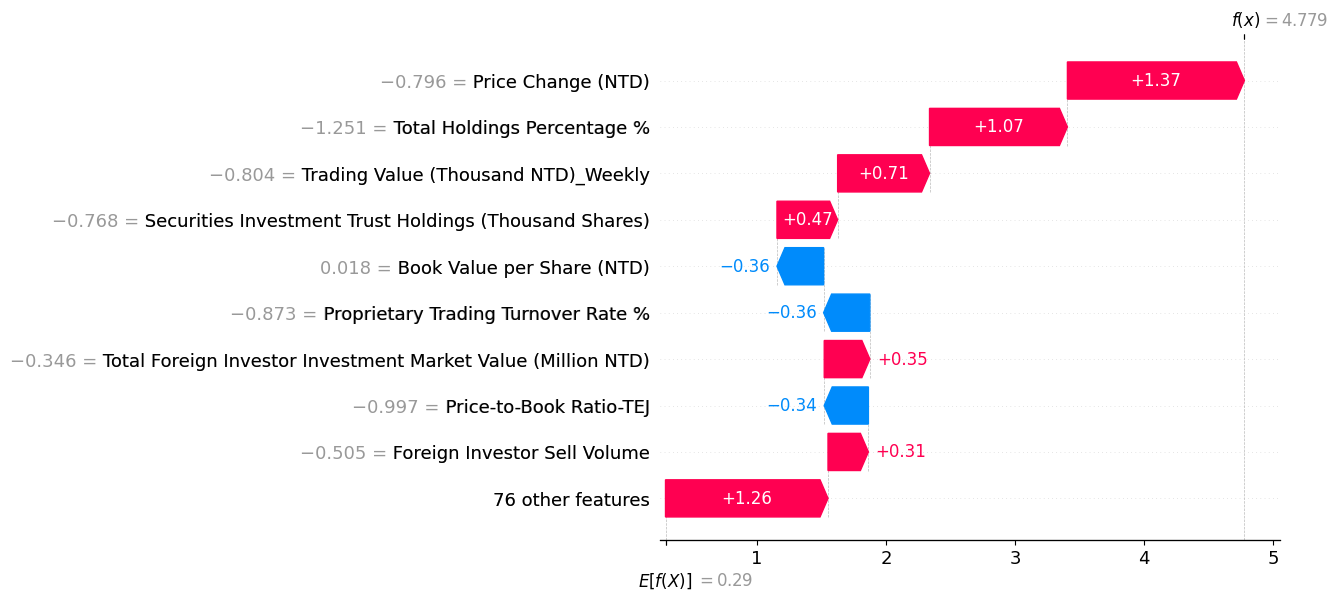

In [ ]:
shap.plots.waterfall(shap_values[0])

##### prob2

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

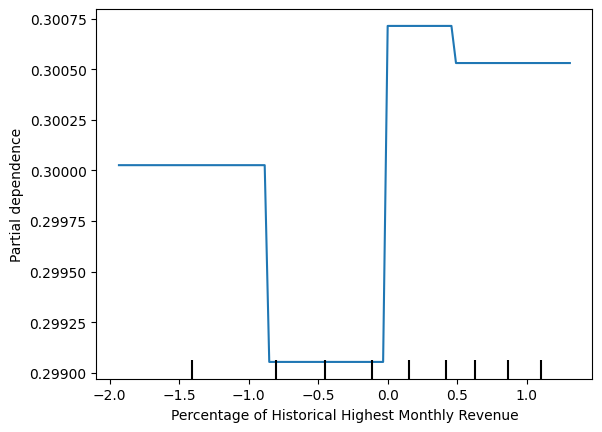

In [ ]:
pdp_percentage_of_historical = PartialDependenceDisplay.from_estimator(rfr, X_train, ['Percentage of Historical Highest Monthly Revenue'])

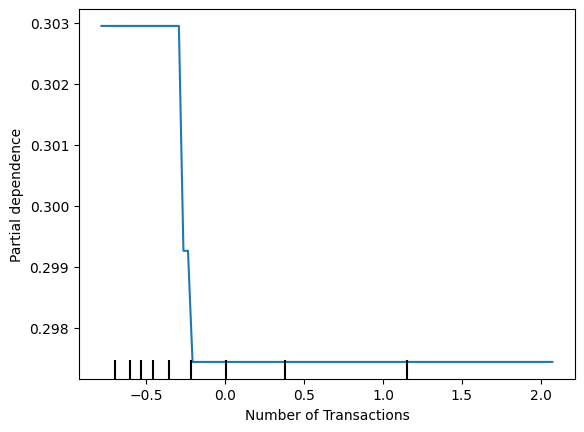

In [ ]:
pdp_num_of_transaction = PartialDependenceDisplay.from_estimator(rfr, X_train, ['Number of Transactions'])

# Others

### NN first version

###### settings

In [ ]:
!pip install ray
!pip install -U tensorboardx
!pip install mlflow
import tensorflow
tensorflow.__version__

In [ ]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial
from ray.air import Checkpoint, session
from ray.tune import Tuner
from ray import tune
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

###### model

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

class TwoLayer(nn.Module):
    def __init__(self, i_s, h_s, o_s = 1, num_layer = 1, activation = None):
      super(TwoLayer, self).__init__()
      self.w1 = nn.Linear(i_s, h_s)
      self.w2 = nn.Linear(h_s, i_s)
      self.w3 = nn.Linear(i_s, o_s)
      self.dropout1 = nn.Dropout(0.25)
      self.dropout2 = nn.Dropout(0.5)
      self.norm1 = nn.BatchNorm1d(h_s)
      self.norm2 = nn.BatchNorm1d(i_s)
      self.activation_f = nn.ReLU()
      self.activation = activation
    def forward(self, x, last = False):
      # a = x
      x = self.w1(x)
      if self.activation == True:
        x = self.activation_f(x)
      x = self.norm1(x)

      x = self.w2(x)
      if self.activation == True:
        x = self.activation_f(x)
      x = self.norm2(x)
      # x = a+x
      if last == True:
        x = self.w3(x)
      return x

class Net(nn.Module):
    def __init__(self, layer, num_layer = 1):
      super(Net, self).__init__()
      self.num_layer = num_layer
      self.layer = layer
      self.layers = clones(self.layer, self.num_layer)

    def forward(self, X):
      output = X
      for k, mod in enumerate(self.layers):
        if (k+1) == self.num_layer:
          output = mod(output, last = True)
        else:
          output = mod(output)
      return output

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  pass
print('Found GPU at: {}'.format(device_name))

###### tuning hyperparameter

In [ ]:
def load_data(data_dir):
  with open("/content/drive/MyDrive/data/data.pickle", "rb") as f:
    d_ = pickle.load(f)
  return d_

# tune
def train(config, data):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  epoch = config["epoch"]
  X_train, y_train, X_test, y_test = data[0], data[1], data[2], data[3]
  dataset = Data(torch.tensor(np.array(X_train), dtype = torch.float32),
          torch.tensor(np.array(y_train), dtype = torch.float32))
  train_loader = DataLoader(dataset, batch_size=256, shuffle=False)
  val_dataset = Data(torch.tensor(np.array(X_test), dtype = torch.float32),
          torch.tensor(np.array(y_test), dtype = torch.float32))
  test_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
  layer = TwoLayer(X_train.shape[1], config["node_size"], 1, config["activation"]).to(device)
  model = Net(layer,config["layer_clone"]).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

  loss_f = nn.MSELoss()
  loss_old = 100000
  loss_all = 0
  for s in range(epoch):
    loss_all = 0
    for i, (X, y) in enumerate(train_loader):
      output = torch.squeeze(model(X.to(device)))

      loss = loss_f(output, y.to(device))
      for k, mod in enumerate(model.layers):
        if config["regulariztion"] == True:
          loss += config["reg_coef"] \
            * (torch.sum(mod.w1.bias**2)+torch.sum(mod.w2.bias**2) + torch.sum(mod.w1.weight**2)+torch.sum(mod.w2.weight**2))
        if config["regulariztion"] == False:
          pass
      loss.backward()

      if config["scheduler"] == "cosine":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150, eta_min=0, last_epoch=- 1, verbose=False)
        scheduler.step()

      if config["scheduler"] == "None":
        optimizer.step()

      optimizer.zero_grad()
      loss_all += loss
    if loss_all > loss_old:
      model.load_state_dict(torch.load('model.pth'))
      optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.8
      if optimizer.param_groups[0]['lr'] < 1e-5:
        break
    else:
      torch.save(model.state_dict(), 'model.pth')
      loss_old = loss_all
    print(f"epoch:{s}. loss = {loss_all/i+1}")

  val_loss = 0
  for i, (X, y) in enumerate(test_loader):
    with torch.no_grad():
      output = torch.squeeze(model(X.to(device)))
      val_loss = loss_f(output, y.to(device))
  val_steps = i+1

  # tune.report(loss = (val_loss / val_steps).cpu())
  return output

In [ ]:
# tune
# | train_8a7b4_00000 | TERMINATED | 172.28.0.12:61843 | activation <built-in metho_9260 |
# batch 256 | epcoh  40 | layers 9 | lr 0.01 | node 308 | reg coef 0.001 | reg False | scheduler None | tensor(35.1675) |
# | train_5677d_00015 | TERMINATED | 172.28.0.12:9850 | <built-in metho_c040 |
#  256 |      44 |             6 | 0.000685502 |         225 |     0.001  | True            | None        | tensor(35.5661) |                    1 |
import mlflow
import gc
gc.collect()
def main(num_samples=10, max_num_epochs=1):
  data_dir = os.path.abspath("/content/drive/MyDrive/data/")
  d_ = load_data(data_dir)

  start, train_end, test_end = initialization()
  X_train, y_train, X_test, y_test, weight = split_data(d_, start, train_end, test_end)
  data = (X_train, y_train, X_test, y_test, weight)
  config = {
      "node_size": tune.randint(4, 512),
      "activation": tune.choice([True, False]),
      "layer_clone": tune.randint(1, 10),
      # "opt": tune.choice(["sgd"]),
      "batch_size": tune.choice([256]),
      "epoch": tune.randint(10, 50),
      "scheduler": tune.choice(["cosine", "None"]),
      "regulariztion": tune.choice([True, False]),
      "lr": tune.loguniform(0.1,0.0001),
      "reg_coef": tune.choice([0.01, 0.001, 0.0001])

  }

  scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2)

  reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "accuracy", "training_iteration"])

  result = tune.run(
    partial(train, data = data),
    resources_per_trial={"cpu": 2, "gpu": 1},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter, verbose=3
    )


  best_trial = result.get_best_trial("loss", "min", "last")
  print("Best trial config: {}".format(best_trial))
  print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
  print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

  return result
"""
if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=20, max_num_epochs=3)"""

##### training

In [ ]:
# train
# | train_8a7b4_00000 | TERMINATED | 172.28.0.12:61843 | activation <built-in metho_9260 |
# batch 256 | epcoh  40 | layers 9 | lr 0.01 | node 308 | reg coef 0.001 | reg False | scheduler None | tensor(35.1675) |
# |   256 |    45  |     1 | 0.00262791|    477 |     0.0001 | False    | None       | tensor(14.2560) |                    1 |
# |<built-in metho_8680
      # "opt": tune.choice(["sgd"]),
config = {
      "node_size": 477,
      "activation": torch.relu,
      "layer_clone": 1,
      "batch_size": 256,
      "epoch": 45,
      "scheduler": "None",
      "regulariztion": False,
      "lr": 0.0026,
      "reg_coef": 0.0001
  }
from sklearn.decomposition import PCA
start, train_end, test_end = initialization()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_acc = []
nn_pred = pd.DataFrame()
nn_ret = pd.DataFrame()
i = 0
loss_f = nn.MSELoss()
while True:
    # data
    i+=1
    print("-------------rolling {%i}----------------"%i)
    # data
    X_train, y_train, X_test, y_test, weight = split_data(d_, start, train_end, test_end)
    if X_test.shape[0] == 0:
      # update data
      start, train_end, test_end = update(start, train_end, test_end)
      continue
    data = (X_train, y_train, X_test, y_test, weight)

    y_hat = train(config, data)
    # quantile sort and return
    # ---------------groupby----------------
    y_hat = pd.DataFrame(y_hat.cpu().detach().numpy(), columns = ["pred"]).set_index(y_test.index)
    nn_pred, nn_ret = compute_ret(y_test, y_hat, nn_pred, nn_ret)
    print(nn_ret)
    # update data
    start, train_end, test_end = update(start, train_end, test_end)
    with open("/content/drive/MyDrive/result/nn_ret.pickle", "wb") as f:
      pickle.dump(nn_ret, f)
    with open("/content/drive/MyDrive/result/nn_pred.pickle", "wb") as f:
      pickle.dump(nn_pred, f)
    if test_end > max(d_.reset_index()["年月日"]):
      break